# 문제 정의

In [ ]:
# 당뇨로 인해 30일 내에 병원에 재입원할 여부를 예측. 분류 모델을 만들 것.

# 데이터 탐색 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv("./diabetic_data.csv")

In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

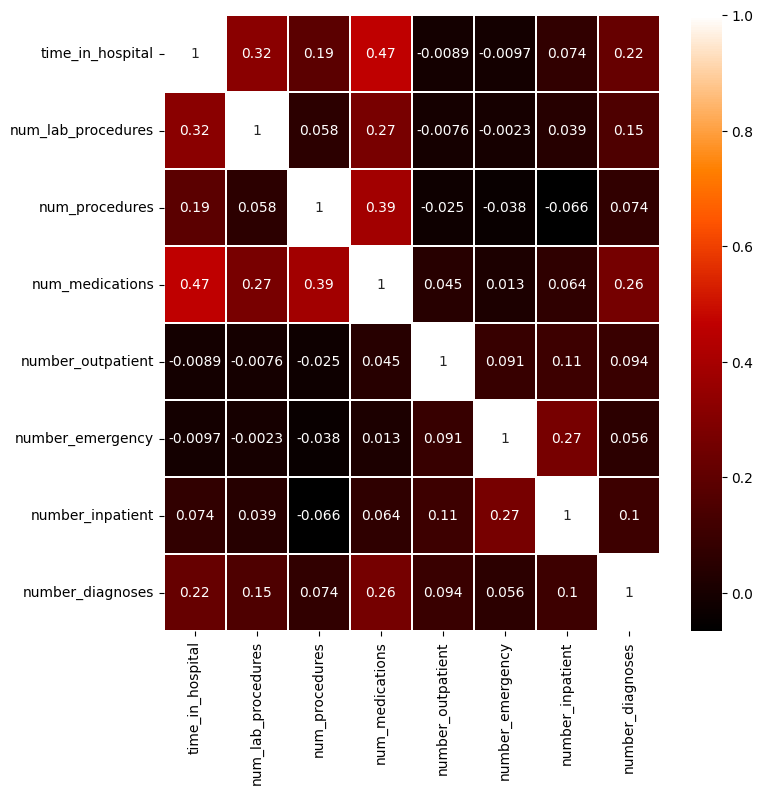

In [ ]:
selected_columns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

# 서브셋 생성
subset_df = df[selected_columns]

# 상관관계 히트맵 그리기
colormap = plt.cm.gist_heat
plt.figure(figsize=(8, 8))
sns.heatmap(subset_df.corr(), linewidths=0.1, cmap=colormap, linecolor='white', annot=True)
plt.show()

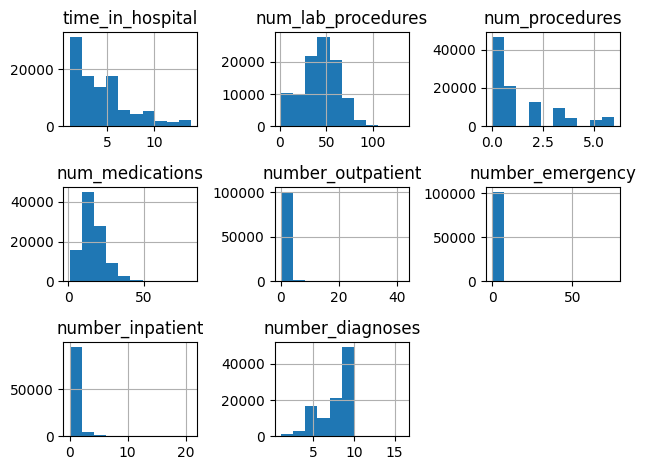

In [ ]:
import matplotlib.pyplot as plt

selected_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                    'num_medications', 'number_outpatient', 'number_emergency',
                    'number_inpatient', 'number_diagnoses']

# 히스토그램
df[selected_columns].hist()
plt.tight_layout()
plt.show()

In [ ]:
len(df['readmitted'])

101766

In [ ]:
df['readmitted']=df['readmitted'].replace(['NO','>30','<30'],['0','0','1']) #30일 이후에 입원한건 병원과 연관 없으니 0으로 replace
df['readmitted']=df['readmitted'].astype('int')

In [ ]:
#dropping encounter_id,patient_nbr as it is just identifier
#weight as it contains 97% null values
#examide, citogliption as they have only one categorical value
#diag_1,diag_2,diag_3 as we are considering number_of_diagnosis
df=df.drop(['encounter_id','patient_nbr','weight','examide','citoglipton','diag_1','diag_2','diag_3'],axis=1)

In [ ]:
df.replace('?',np.nan,inplace=True) #물음표 문자열이기때문에 nan으로 변환, inplace =true니까 원본데이터 바꾼것

In [ ]:
df.isnull().sum() #null값 계수 세기 (race 정도는 살릴 수 있을것)

,0
race,2273
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
payer_code,40256
medical_specialty,49949
num_lab_procedures,0


In [ ]:
#discharge_disposition_id informs where the patient has gone after discharging. Ids 11,13,14,19,20,21 represent death or Hospice they cannot be returned
#data 자체를 지우는 경우. 사망했거나 요양병원으로 간 경우라서 지움, ~가 빼라는 뜻. df에서 제외시키는 것
df=df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [ ]:
#Numerical Columns in dataset
#수치형 data부터 보는것 > null값 없는거 확인
df_num_cols=df[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']]
df_num_cols.isnull().sum()

,0
time_in_hospital,0
num_lab_procedures,0
num_procedures,0
num_medications,0
number_outpatient,0
number_emergency,0
number_inpatient,0
number_diagnoses,0


In [ ]:
#수치형 data들
df_num_cols=pd.concat([df_num_cols],axis=1)

In [ ]:
df_num_cols.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')

In [ ]:
#수치형 data들은 상관관계 파악 가능 > 큰 문제 없어보임
df_num_cols.corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.319855,0.189908,0.463757,-0.009214,-0.009573,0.074251,0.220600
num_lab_procedures,0.319855,1.000000,0.051715,0.265148,-0.007610,-0.000980,0.039908,0.149663
num_procedures,0.189908,0.051715,1.000000,0.381931,-0.025263,-0.038715,-0.067021,0.070460
num_medications,0.463757,0.265148,0.381931,1.000000,0.046037,0.014028,0.065266,0.261639
number_outpatient,-0.009214,-0.007610,-0.025263,0.046037,1.000000,0.091668,0.108015,0.094829
number_emergency,-0.009573,-0.000980,-0.038715,0.014028,0.091668,1.000000,0.267702,0.055994
number_inpatient,0.074251,0.039908,-0.067021,0.065266,0.108015,0.267702,1.000000,0.104737
number_diagnoses,0.220600,0.149663,0.070460,0.261639,0.094829,0.055994,0.104737,1.000000


In [ ]:
#대부분이 범주형 변수
#Categorical Columns in dataset
categorical_columns=['race', 'gender','payer_code','max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

In [ ]:
df['race']=df['race'].fillna('UKN')  #비어있다는것을 알기 위해 unknown으로 일단 채워두는것
df['medical_specialty']=df['medical_specialty'].fillna('UKN')
df['payer_code']=df['payer_code'].fillna('UKN')


In [ ]:
#사망 .. case 빼고 컬럼 몇개 빼서 데이터 형태 바뀜
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,UKN,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,UKN,UKN,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,UKN,UKN,11,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,UKN,UKN,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,UKN,UKN,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),1,3,7,3,MC,UKN,51,...,No,Down,No,No,No,No,No,Ch,Yes,0
101762,AfricanAmerican,Female,[80-90),1,4,5,5,MC,UKN,33,...,No,Steady,No,No,No,No,No,No,Yes,0
101763,Caucasian,Male,[70-80),1,1,7,1,MC,UKN,53,...,No,Down,No,No,No,No,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),2,3,7,10,MC,Surgery-General,45,...,No,Up,No,No,No,No,No,Ch,Yes,0


In [ ]:
#누가 진단한지 본것
df1=df.groupby('medical_specialty').size().sort_values(ascending=False)

In [ ]:
df1.head(10) #10개만 보여준건데 뒤로갈수록 드물어진다 > 이런 경우에 많은 애들만 살리고 나머지는 Other로 처리하는게 좋을것 (희소하기 때문에)

,0
medical_specialty,
UKN,48616
InternalMedicine,14237
Emergency/Trauma,7419
Family/GeneralPractice,7252
Cardiology,5279
Surgery-General,3059
Nephrology,1539
Orthopedics,1392
Orthopedics-Reconstructive,1230


In [ ]:
top_10=['UKN','InternalMedicine','Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General','Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']

In [ ]:
#나머지 other 로
df.loc[~df.medical_specialty.isin(top_10),'medical_specialty']= 'Other'

In [ ]:
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000
mean,2.030259,3.517882,5.731083,4.379332,42.906929,1.334236,15.979062,0.369246,0.198444,0.630935,7.401709,0.113888
std,1.446373,5.184359,4.065029,2.968409,19.610032,1.702786,8.094909,1.265142,0.937734,1.260428,1.941013,0.317677
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000


In [ ]:
#원핫 인코딩하면 col이 너무 커질것 > string으로 datatype 바꾸면 숫자로 처리 안할거니까 변환
df['admission_type_id']=df['admission_type_id'].astype('str')
df['discharge_disposition_id']=df['discharge_disposition_id'].astype('str')
df['admission_source_id']=df['admission_source_id'].astype('str')

In [ ]:
df['admission_type_id'].unique()

array(['6', '1', '2', '3', '4', '5', '8', '7'], dtype=object)

In [ ]:
#모델을 저장하듯이 전처리한 data도 저장 가능. 이제 이걸 읽어와서 진행하면 되는것
df.to_csv('df_naive.csv')
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,UKN,Other,41,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,UKN,UKN,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,UKN,UKN,11,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,UKN,UKN,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,UKN,UKN,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),1,3,7,3,MC,UKN,51,...,No,Down,No,No,No,No,No,Ch,Yes,0
101762,AfricanAmerican,Female,[80-90),1,4,5,5,MC,UKN,33,...,No,Steady,No,No,No,No,No,No,Yes,0
101763,Caucasian,Male,[70-80),1,1,7,1,MC,UKN,53,...,No,Down,No,No,No,No,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),2,3,7,10,MC,Surgery-General,45,...,No,Up,No,No,No,No,No,Ch,Yes,0


In [ ]:
#범주형 변수들은 one-hot encoding
df_cat=pd.get_dummies(df[categorical_columns+ ['admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty']],drop_first=True)

In [ ]:
list(df_cat)

['race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_UKN',
 'gender_Male',
 'gender_Unknown/Invalid',
 'payer_code_CH',
 'payer_code_CM',
 'payer_code_CP',
 'payer_code_DM',
 'payer_code_FR',
 'payer_code_HM',
 'payer_code_MC',
 'payer_code_MD',
 'payer_code_MP',
 'payer_code_OG',
 'payer_code_OT',
 'payer_code_PO',
 'payer_code_SI',
 'payer_code_SP',
 'payer_code_UKN',
 'payer_code_UN',
 'payer_code_WC',
 'max_glu_serum_>300',
 'max_glu_serum_Norm',
 'A1Cresult_>8',
 'A1Cresult_Norm',
 'metformin_No',
 'metformin_Steady',
 'metformin_Up',
 'repaglinide_No',
 'repaglinide_Steady',
 'repaglinide_Up',
 'nateglinide_No',
 'nateglinide_Steady',
 'nateglinide_Up',
 'chlorpropamide_No',
 'chlorpropamide_Steady',
 'chlorpropamide_Up',
 'glimepiride_No',
 'glimepiride_Steady',
 'glimepiride_Up',
 'acetohexamide_Steady',
 'glipizide_No',
 'glipizide_Steady',
 'glipizide_Up',
 'glyburide_No',
 'glyburide_Steady',
 'glyburide_Up',
 'tolbutamide_Steady',
 'pioglitazone_No',
 '

In [ ]:
df_cat

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UKN,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,payer_code_CP,...,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Other,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UKN
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
101762,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
101763,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
101764,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
df_num_cols

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1,41,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9
2,2,11,5,13,2,0,1,6
3,2,44,1,16,0,0,0,7
4,1,51,0,8,0,0,0,5
...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9
101762,5,33,3,18,0,0,1,9
101763,1,53,0,9,1,0,0,13
101764,10,45,2,21,0,0,1,9


In [ ]:
df['age'] #age 처리 필요

,age
0,[0-10)
1,[10-20)
2,[20-30)
3,[30-40)
4,[40-50)
...,...
101761,[70-80)
101762,[80-90)
101763,[70-80)
101764,[80-90)


In [ ]:
dff=pd.concat([df_cat,df_num_cols,df['age']],axis=1) #앞에 처리해둔것과 붙임, 가로로 붙임

In [ ]:
len(dff)

99343

In [ ]:
dff

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UKN,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,payer_code_CP,...,medical_specialty_UKN,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age
0,False,True,False,False,False,False,False,False,False,False,...,False,1,41,0,1,0,0,0,1,[0-10)
1,False,True,False,False,False,False,False,False,False,False,...,True,3,59,0,18,0,0,0,9,[10-20)
2,False,False,False,False,False,False,False,False,False,False,...,True,2,11,5,13,2,0,1,6,[20-30)
3,False,True,False,False,False,True,False,False,False,False,...,True,2,44,1,16,0,0,0,7,[30-40)
4,False,True,False,False,False,True,False,False,False,False,...,True,1,51,0,8,0,0,0,5,[40-50)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,False,False,False,False,False,True,False,False,False,False,...,True,3,51,0,16,0,0,0,9,[70-80)
101762,False,False,False,False,False,False,False,False,False,False,...,True,5,33,3,18,0,0,1,9,[80-90)
101763,False,True,False,False,False,True,False,False,False,False,...,True,1,53,0,9,1,0,0,13,[70-80)
101764,False,True,False,False,False,False,False,False,False,False,...,False,10,45,2,21,0,0,1,9,[80-90)


In [ ]:
dff.dtypes

,0
race_Asian,bool
race_Caucasian,bool
race_Hispanic,bool
race_Other,bool
race_UKN,bool
...,...
number_outpatient,int64
number_emergency,int64
number_inpatient,int64
number_diagnoses,int64


In [ ]:
#범주형으로 바꾸기. dictionary를 만들고 열을 추가해서 대치 진행
age_id = {'[0-10)':5,
          '[10-20)':15,
          '[20-30)':25,
          '[30-40)':35,
          '[40-50)':45,
          '[50-60)':55,
          '[60-70)':65,
          '[70-80)':75,
          '[80-90)':85,
          '[90-100)':95}
dff['age_group'] = dff.age.replace(age_id)

In [ ]:
dff.columns

Index(['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'race_UKN', 'gender_Male', 'gender_Unknown/Invalid', 'payer_code_CH',
       'payer_code_CM', 'payer_code_CP',
       ...
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age', 'age_group'],
      dtype='object', length=141)

In [ ]:
dff=pd.concat([dff,df['readmitted']],axis=1) #이어서 붙이기

In [ ]:
dff.columns

Index(['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'race_UKN', 'gender_Male', 'gender_Unknown/Invalid', 'payer_code_CH',
       'payer_code_CM', 'payer_code_CP',
       ...
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'age', 'age_group', 'readmitted'],
      dtype='object', length=142)

In [ ]:
dff.dtypes

,0
race_Asian,bool
race_Caucasian,bool
race_Hispanic,bool
race_Other,bool
race_UKN,bool
...,...
number_inpatient,int64
number_diagnoses,int64
age,object
age_group,int64


In [ ]:
#칼럼 만들어서 이제 필요없으니까 drop 하기
dff=dff.drop(['age'],axis=1)

In [ ]:
dff.dtypes

,0
race_Asian,bool
race_Caucasian,bool
race_Hispanic,bool
race_Other,bool
race_UKN,bool
...,...
number_emergency,int64
number_inpatient,int64
number_diagnoses,int64
age_group,int64


In [ ]:
df=dff

In [ ]:
import pandas as pd
#df = pd.read_csv('./df.csv')

df.corr()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UKN,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,payer_code_CP,...,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_group,readmitted
race_Asian,1.000000,-0.137092,-0.011482,-0.009782,-0.012098,0.005587,-0.000438,0.000344,-0.001757,-0.008644,...,-0.011305,-0.007866,0.000007,-0.027157,-0.013140,-0.009159,-0.010603,-0.015264,0.001773,-0.002607
race_Caucasian,-0.137092,1.000000,-0.247436,-0.210791,-0.260697,0.055796,-0.009445,0.002397,-0.017092,0.019741,...,-0.006125,-0.024138,0.032885,0.057437,0.058531,-0.021769,-0.002150,0.109863,0.168633,0.007524
race_Hispanic,-0.011482,-0.247436,1.000000,-0.017655,-0.021835,-0.000092,-0.000791,-0.003557,-0.004804,0.001804,...,-0.015944,-0.001632,-0.019246,-0.035363,-0.004726,0.004851,-0.002016,-0.036339,-0.063343,-0.003980
race_Other,-0.009782,-0.210791,-0.017655,1.000000,-0.018601,0.009541,0.014487,-0.002435,-0.002358,-0.006179,...,-0.005035,0.001678,0.014092,-0.013289,-0.010374,0.005943,-0.017235,-0.015509,-0.025632,-0.006201
race_UKN,-0.012098,-0.260697,-0.021835,-0.018601,1.000000,0.011184,0.023877,-0.002144,-0.013591,0.005038,...,-0.004356,0.008451,-0.004054,-0.003902,-0.021031,-0.024857,-0.039403,-0.057624,0.005907,-0.014197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
number_emergency,-0.009159,-0.021769,0.004851,0.005943,-0.024857,-0.021463,-0.001163,-0.002608,0.010551,-0.013962,...,-0.009573,-0.000980,-0.038715,0.014028,0.091668,1.000000,0.267702,0.055994,-0.087568,0.060885
number_inpatient,-0.010603,-0.002150,-0.002016,-0.017235,-0.039403,-0.015188,-0.002751,-0.010061,-0.006691,-0.025608,...,0.074251,0.039908,-0.067021,0.065266,0.108015,0.267702,1.000000,0.104737,-0.044337,0.168326
number_diagnoses,-0.015264,0.109863,-0.036339,-0.015509,-0.057624,-0.003421,-0.003969,0.006858,0.032343,0.008346,...,0.220600,0.149663,0.070460,0.261639,0.094829,0.055994,0.104737,1.000000,0.241269,0.053580
age_group,0.001773,0.168633,-0.063343,-0.025632,0.005907,-0.050515,0.002041,-0.008617,0.045918,-0.081214,...,0.107077,0.016323,-0.027885,0.043166,0.023671,-0.087568,-0.044337,0.241269,1.000000,0.022196


In [ ]:
df = df.sample(n = len(df)) #sample로 섞음. 원래 몇개 뽑으라는건데 전체를 택했으니..
df = df.reset_index(drop = True)

In [ ]:
df_valid_test=df.sample(frac=0.30) # 30퍼 떼어내서 valid_test로

In [ ]:
df_test = df_valid_test.sample(frac = 0.5) #test data
df_valid = df_valid_test.drop(df_test.index)
df_train=df.drop(df_valid_test.index)

In [ ]:
def calc_prevalence(y_actual):  #y값이 admitted. 불균형 분포가 일어날까봐 어느정도 있는지 재보는 함수 만든것
    return (sum(y_actual)/len(y_actual))

In [ ]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.readmitted.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.readmitted.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.readmitted.values)))

#결과 보면 비슷하게 1이 들어있다는 것을 알 수 있음. 균형이 맞아야...

Test prevalence(n = 14902):0.111
Valid prevalence(n = 14901):0.115
Train all prevalence(n = 69540):0.114


In [ ]:
#readmitted이 1인 애들만 뽑은것
rows_pos = df_train.readmitted == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))],axis = 0)

# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)


In [ ]:
df_train

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UKN,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,payer_code_CP,...,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_group,readmitted
0,False,False,False,False,True,False,False,False,False,False,...,4,37,0,13,0,0,1,8,45,0
1,False,False,False,False,False,True,False,False,False,False,...,6,44,2,18,1,0,2,9,55,1
2,False,True,False,False,False,False,False,False,False,False,...,5,44,0,9,0,0,0,9,65,1
3,False,True,False,False,False,False,False,False,False,False,...,7,54,6,37,0,0,0,6,55,0
4,False,False,False,False,False,False,False,False,False,False,...,2,44,0,7,0,0,0,9,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15915,False,True,False,False,False,True,False,False,False,False,...,3,7,2,23,0,0,0,5,65,0
15916,False,True,False,False,False,True,False,False,False,False,...,8,37,2,10,0,0,1,5,75,1
15917,False,False,False,False,False,False,False,False,False,False,...,4,38,0,15,0,0,1,9,45,1
15918,False,True,False,False,False,True,False,False,False,False,...,4,44,0,7,0,0,2,5,45,0


In [ ]:
#y 붙은 애들을 맞춰야함
X_train = df_train.loc[:, df_train.columns != 'readmitted']
y_train=df_train['readmitted']
X_valid =  df_valid.loc[:, df_valid.columns != 'readmitted']
y_valid=df_valid['readmitted']

In [ ]:
#얘네들로 test 진행해보면 된다
X_test =  df_test.loc[:, df_test.columns != 'readmitted']
y_test=df_test['readmitted']

In [ ]:
#하려면 앞으로 가서 진행해도 되는것. 안해도 ok
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
df_train.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_group,readmitted
count,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000,15920.000000
mean,4.562626,43.471168,1.314259,16.307601,0.397299,0.269284,0.886683,7.527513,66.204146,0.500000
std,3.010040,19.411411,1.680579,8.132789,1.264953,1.189992,1.629468,1.868199,15.817479,0.500016
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,55.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000,65.000000,0.500000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,75.000000,1.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,64.000000,19.000000,16.000000,95.000000,1.000000


In [ ]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [ ]:
X_test_tf = scaler.transform(X_test)

In [ ]:
y_test

,readmitted
90366,0
92642,0
74394,1
93180,0
32729,1
...,...
60423,0
74852,0
6998,0
1628,0


In [ ]:
pd.DataFrame(X_train_tf)[9].unique()

array([-0.1505861,  6.6407191])

In [ ]:
X_train.shape

(15920, 140)

In [ ]:
X_train_tf.shape

(15920, 140)

In [ ]:
#about score. 함수 이용해도 ok
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
thresh = 0.5

In [ ]:
#모델을 저장하듯이 전처리한 data도 저장 가능. 이제 이걸 읽어와서 진행하면 되는것
df.to_csv('df.csv')
df

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UKN,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,payer_code_CP,...,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_group,readmitted
0,False,True,False,False,False,False,False,False,False,False,...,3,53,2,24,1,0,0,9,85,1
1,False,True,False,False,False,True,False,False,False,False,...,5,21,4,29,1,1,4,9,75,0
2,False,False,False,False,False,False,False,False,False,False,...,9,51,1,10,0,0,0,9,65,0
3,False,True,False,False,False,False,False,False,False,False,...,3,65,2,19,0,0,0,9,65,0
4,False,True,False,False,False,False,False,False,False,False,...,4,40,6,32,0,0,1,9,75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99338,False,True,False,False,False,True,False,False,False,False,...,3,30,0,14,0,0,0,9,65,0
99339,False,False,False,True,False,True,False,False,False,False,...,1,51,0,8,0,0,0,6,85,0
99340,False,False,False,False,False,True,False,False,False,False,...,5,61,0,11,0,0,0,5,35,0
99341,False,True,False,False,False,False,False,False,False,False,...,3,53,0,14,0,0,0,9,65,0


#다양한 머신러닝 알고리즘 적용

## 심층 신경망

In [ ]:
X_train.shape

(15920, 140)

In [ ]:
# 케라스 신경망을 구축
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1
from keras.optimizers import Adam  # Adam 옵티마이저 임포트

import matplotlib.pyplot as plt
import numpy as np


model = Sequential()
model.add(Dense(256, activation='relu', input_dim=140))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.1))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_valid.shape)

(15920, 140)
(15920,)
(14901,)


In [ ]:
#callback함수도 포함해서 실행 - 모델 중간 저장 위한 함수

import os
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

X_train_tf = X_train_tf.astype(int)
y_train = y_train.astype(int)
X_valid_tf = X_valid_tf.astype(int)
y_valid = y_valid.astype(int)
X_train = X_train.astype(int)
y_train = y_train.astype(int)
X_valid = X_valid.astype(int)
y_valid = y_valid.astype(int)



modelpath="./model/{epoch:02d}-{val_loss:.4f}.keras"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

#30회동안 모델이 더 좋아지지 않는지 더 확인
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=25)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=150, batch_size=64, verbose=0, callbacks=[early_stopping_callback,checkpointer])



Epoch 1: val_loss improved from inf to 0.69367, saving model to ./model/01-0.6937.keras

Epoch 2: val_loss improved from 0.69367 to 0.65507, saving model to ./model/02-0.6551.keras

Epoch 3: val_loss improved from 0.65507 to 0.63267, saving model to ./model/03-0.6327.keras

Epoch 4: val_loss improved from 0.63267 to 0.60992, saving model to ./model/04-0.6099.keras

Epoch 5: val_loss did not improve from 0.60992

Epoch 6: val_loss did not improve from 0.60992

Epoch 7: val_loss did not improve from 0.60992

Epoch 8: val_loss improved from 0.60992 to 0.58395, saving model to ./model/08-0.5840.keras

Epoch 9: val_loss did not improve from 0.58395

Epoch 10: val_loss did not improve from 0.58395

Epoch 11: val_loss did not improve from 0.58395

Epoch 12: val_loss did not improve from 0.58395

Epoch 13: val_loss did not improve from 0.58395

Epoch 14: val_loss did not improve from 0.58395

Epoch 15: val_loss did not improve from 0.58395

Epoch 16: val_loss did not improve from 0.58395

Epo

In [ ]:
# 결과 - 정확도
scores = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
print("validation Accuracy: %.2f%%\n" % (scores[1]*100))


Training Accuracy: 72.54%

validation Accuracy: 72.54%



In [ ]:
#Accuracy, precision, recall, f1-score, AUC, (specificity)를 제시
y_valid.shape
model.predict(X_valid).shape

466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(14901, 1)

In [ ]:
# 정의해둔 함수 이용 print_report(y_actual, y_pred, thresh):
from sklearn.metrics import f1_score


y_pred_proba = model.predict(X_valid)  # sigmoid를 사용한 이진 분류의 경우 1차원 배열

# 확률을 0 또는 1로 변환
threshold = 0.5  # 일반적인 0.5 사용
y_pred = (y_pred_proba >= threshold).astype(int).ravel()

print_report(y_valid, y_pred, 0.5)

#f1만 추가로 계산하기
print('f1_score:'+ str(f1_score(y_valid, y_pred)))

466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC:0.585
accuracy:0.565
recall:0.612
precision:0.152
specificity:0.559
prevalence:0.115
 
f1_score:0.24369747899159663


# randomforest 모델- 앙상블 알고리즘

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings


# 랜덤 포레스트 기본 모델
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_valid)
accuracy = accuracy_score(y_valid , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))



랜덤 포레스트 정확도: 0.6322


In [ ]:
#랜덤 포레스트 파라미터 조절한 모델
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [5, 10, 12, 15],
    'min_samples_leaf' : [1, 2, 5],
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf_pa = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf_pa , param_grid=params , cv=3, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 5}
최고 예측 정확도: 0.6134


In [ ]:
# 정의해둔 함수 이용 print_report(y_actual, y_pred, thresh):
from sklearn.metrics import f1_score


y_pred = rf_clf.predict(X_valid)
y_pred.ravel()


print_report(y_valid, y_pred.ravel(), 0.5)

#f1만 추가로 계산하기
print('f1_score:'+ str(f1_score(y_valid, y_pred.ravel())))

AUC:0.617
accuracy:0.632
recall:0.598
precision:0.176
specificity:0.637
prevalence:0.115
 
f1_score:0.2714342682440516


#GBM 모델 - 부스팅

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_valid)


gb_accuracy = accuracy_score(y_valid, gb_pred)
print('gbm 모델 정확도:{0:.4f}'.format(gb_accuracy))

gbm 모델 정확도:0.6635


In [ ]:
#파라미터 조절해보기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 150, 200],
    'learning_rate' : [0.05, 0.08, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=3 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 200}
최고 예측 정확도: 0.6161


In [ ]:
# 정의해둔 함수 이용 print_report(y_actual, y_pred, thresh):
from sklearn.metrics import f1_score


y_pred = gb_clf.predict(X_valid)
y_pred.ravel()


print_report(y_valid, y_pred.ravel(), 0.5)

#f1만 추가로 계산하기
print('f1_score:'+ str(f1_score(y_valid, y_pred.ravel())))

AUC:0.625
accuracy:0.664
recall:0.575
precision:0.186
specificity:0.675
prevalence:0.115
 
f1_score:0.2814560045858412


# 실험 결과



In [ ]:
## 정확도가 가장 높은 심층신경망 모델 사용/ 최종 모델로 test 진행
X_test = X_test.astype(int)
y_test = y_test.astype(int)

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))



466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6252 - loss: 0.6260

 Test Accuracy: 0.6301


466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


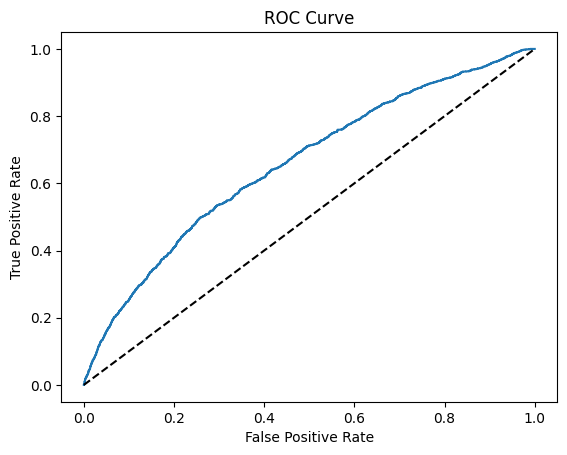

<Figure size 640x480 with 0 Axes>

In [ ]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(X_test)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()

In [ ]:
# prompt: ROC AUC 값 출력

from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_test_pred_probs)
print('ROC AUC: %.3f' % roc_auc)


ROC AUC: 0.658


466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[8410 4845]
 [ 667  980]]


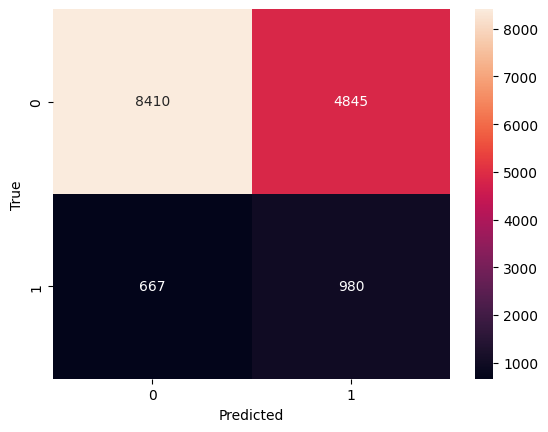

In [ ]:
# prompt: confusion matrix 출력

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# prompt: classification report 출력

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     13255
           1       0.17      0.60      0.26      1647

    accuracy                           0.63     14902
   macro avg       0.55      0.61      0.51     14902
weighted avg       0.84      0.63      0.70     14902

